## Example of GCM downscaling

After the statistical downscaling methods and different predictor sets have been evaluated in a cross-validation approach (see `script02_downscalingCV.ipynb`), the same configuration is applied to Global climate Model (GCM) data to produce local climate projections. This is shown in the present notebook.

We first load the required R libraries:

In [ ]:
rm(list=ls())
library(loadeR) # part of climate4R:  load data
library(transformeR) # part of climate4R:  data manipulation and analysis
library(downscaleR) # part of climate4R: downscaling and bias correction
library(visualizeR)# part of climate4R: visualization
library(lattice) # to use some functionalities of spplot directly 
library(sp) # bpy.colors
library(RColorBrewer) # color themes

Loading required package: rJava

Loading required package: loadeR.java

Java version 23x amd64 by N/A detected

The maximum JVM heap space available is: 2.00 GB

NetCDF Java Library Version: 4.6.0-SNAPSHOT (Built-On: 20150423.1338) loaded and ready

You can manually set the NetCDF Java Library version before loading the package:
options(loadeR.java_forced_version = "X.Y.Z")
library(loadeR.java)

netCDF-Java CLASSPATH from bundled java package directory: /home/ana/micromamba/envs/prosecco/lib/R/library/loadeR.java/java:/home/ana/micromamba/envs/prosecco/lib/R/library/loadeR.java/java/netcdfAll-4.6.0-SNAPSHOT.jar

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.4 (2025-08-07) is loaded

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.5) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

downscaleR version 3.3.4 (2023-06-22) is loaded

Please use 'citation("downscaleR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.



In [ ]:
work.dir <- "/home/ana/WORK_local/DATA/Prosecco/data4notebooks/" # to be removed once the data are on the server

We define some arguments which eill be later used when representing the maps of the region of study:

In [4]:
# provinces polygon
sh <- readRDS(paste0(work.dir,"italy_admin.rds")) # read shape file
proj4string(sh) = CRS("+init=epsg:4326")
sh = as(sh, "SpatialPolygons")

# plot limits
lats <- c(45.45,46.15)
lons <- c(11.7,12.8)

Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+init=epsg:4326")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +datum=WGS84 +no_defs
without reprojecting.
For reprojection, use function spTransform”


## Load predictands

Our predictands are observed daily values of the meteorological variables of interest, in the stations in the region of study, namely daily maximum, mean and minimum temperature, daily mean relative humidity and daily accumulated precipitation.

In [5]:
load(paste0(work.dir,"/observations_subset_1991-2020.Rdata")) # loaded tasmean_obs, tasmin_obs, tasmax_obs, pr_obs, hurs_obs

## Load ERA5 predictors

After testing different predictors's set, we finally chose P8 which consist on 14 large-scale variables (e.g. temperature, humidity, winds, geopotential at different vertical levels). Predictions using these predictors (from ERA5) were cross-validated in `script02_downscalingCV.ipynb`. Here we load the selected predictor set from ERA5, which will be used to train the statistical methods.

In [6]:
load(paste0(work.dir,"/ERA5_P8predictors_2deg_1991-2020.Rdata"))
str(x)

List of 4
 $ Variable:List of 2
  ..$ varName: chr [1:14] "u@500" "u@700" "u@850" "v@500" ...
  ..$ level  : num [1:14] 500 700 850 500 700 850 500 850 500 700 ...
  ..- attr(*, "use_dictionary")= chr [1:14] "FALSE" "FALSE" "FALSE" "FALSE" ...
  ..- attr(*, "description")= chr [1:14] "U component of wind" "U component of wind" "U component of wind" "V component of wind" ...
  ..- attr(*, "units")= chr [1:14] "m s**-1" "m s**-1" "m s**-1" "m s**-1" ...
  ..- attr(*, "longname")= chr [1:14] "u" "u" "u" "v" ...
  ..- attr(*, "daily_agg_cellfun")= chr [1:14] "none" "none" "none" "none" ...
  ..- attr(*, "monthly_agg_cellfun")= chr [1:14] "none" "none" "none" "none" ...
  ..- attr(*, "verification_time")= chr [1:14] "none" "none" "none" "none" ...
 $ Data    : num [1:14, 1, 1:10958, 1:3, 1:6] 19.01 10.91 5.89 -6.9 -3.6 ...
  ..- attr(*, "dimensions")= chr [1:5] "var" "member" "time" "lat" ...
 $ xyCoords:List of 2
  ..$ x: num [1:6] 5.88 7.88 9.88 11.88 13.88 ...
  ..$ y: num [1:3] 44.9 46.

## Load GCM data

Here we load the same predictor variables but from one single GCM. These data have been already interpolated to the 2º ERA5 grid and units have been transformed to match ERA5 counterparts. This file corresponds to the historical simulation (until 2005, merged with 2006-2020 from RCP8.5) and RCP8.5 (2006-2100). Note the importance of considering several scenarios (the example below can be re-run with the RCP4.5 data).

In [7]:
load(paste0(work.dir,"/CMIP5-subset_MPI-ESM-MR_r1i1p1_rcp85_P8predictors_2deg_1991-2100.Rdata")) # loaded x_hist, x_rcp

## Prepare GCM data

To account for systematic GCM biases with respect to ERA5, they should be corrected, using a monthly correction.

In [8]:
x_hist_corr <- scaleGrid(x_hist, base = x_hist, ref = x, type = "center", spatial.frame = "gridbox", time.frame = "monthly")
x_rcp_corr <- scaleGrid(x_rcp, base = x_hist, ref = x, type = "center", spatial.frame = "gridbox", time.frame = "monthly")
x_rcp <- x_hist <- NULL

[2026-02-15 21:31:11.811646] - Scaling by months ...



[2026-02-15 21:31:13.184391] - Done

[2026-02-15 21:31:13.185763] - Scaling by months ...

[2026-02-15 21:31:15.826475] - Done



## Downscale GCM in the historical period

First, we produced downscaled data for the historical period. This would be essential, e.g. to estimate the climate change signal (difference between future and historical conditions). For this prupose we use the `downscale` function from `downscaleR` package. This first example is for daily maximum temperature, for which a linear model is used. 15 PCs are retained since they represented 95% of variance in ERA5.

In [9]:
tasmax_down_hist <- downscale(tasmax_obs, x, newdata = x_hist_corr, method ="lm", n.pcs = 15) 

[2026-02-15 21:31:15.887081] - Scaling ...

[2026-02-15 21:31:16.54721] - Done

[2026-02-15 21:31:16.548405] - Scaling ...

[2026-02-15 21:31:17.032429] - Done



Extract data for April-September and represent the mean and the 90th percentile over the historical period.

In [10]:
tasmax_down_hist_subset <- subsetGrid(tasmax_down_hist, season=4:9)
tasmax_down_hist_mean <- climatology(tasmax_down_hist_subset)
tasmax_down_hist_p90 <- climatology(tasmax_down_hist_subset, clim.fun = list("quantile", probs = .9, na.rm = TRUE))

[2026-02-15 21:31:29.806171] - Computing climatology...

[2026-02-15 21:31:29.809508] - Done.

[2026-02-15 21:31:29.814687] - Computing climatology...

[2026-02-15 21:31:29.823457] - Done.



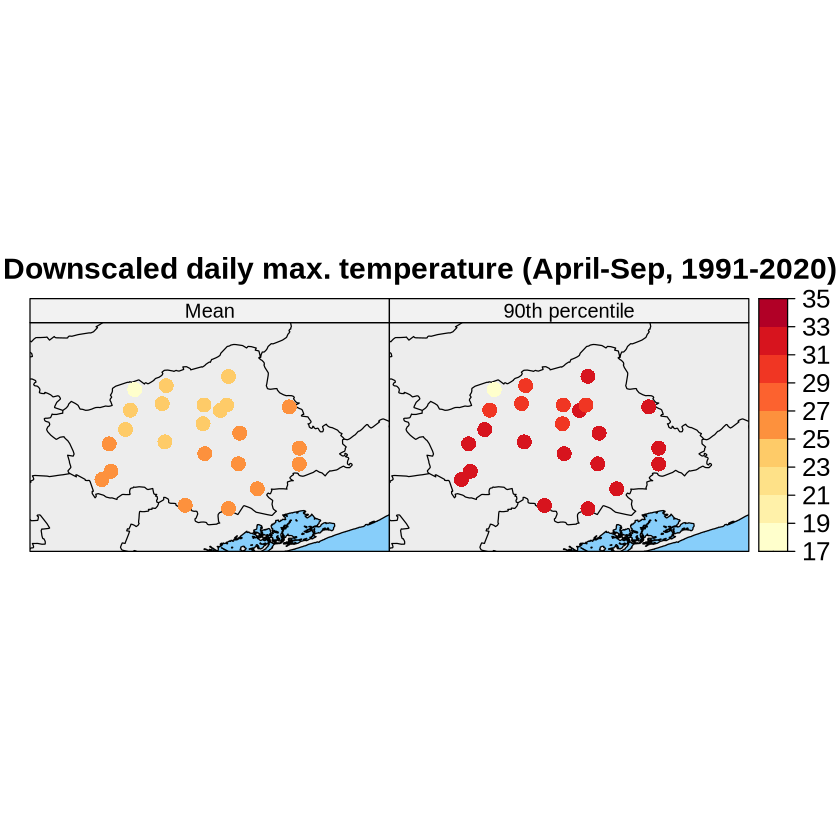

In [11]:
bk <-  seq(17,35,2)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlOrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(makeMultiGrid(tasmax_down_hist_mean, tasmax_down_hist_p90), cex=1.5, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Downscaled daily max. temperature (April-Sep, 1991-2020)", cex=1.5),
    par.strip.text = list(cex = 1), as.table=TRUE, names.attr=c("Mean","90th percentile"), layout= c(2,1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

Example for precipitation:

In [12]:
pr_down_hist <- downscale(pr_obs, x, newdata = x_hist_corr, method ="analogs", wet.threshold = .1, n.pcs = 15)

[2026-02-15 21:31:30.781192] - Scaling ...

[2026-02-15 21:31:31.356813] - Done

[2026-02-15 21:31:31.358039] - Scaling ...

[2026-02-15 21:31:31.869237] - Done



Represent the downscaled precipitation sum in July, in the historical period 1991-2020:

In [13]:
pr_down_hist_jul <- subsetGrid(pr_down_hist, season=7)
pr_down_hist_jul_sum <- aggregateGrid(pr_down_hist_jul, aggr.m = list(FUN = sum, na.rm = TRUE))

[2026-02-15 21:32:30.866037] Performing monthly aggregation...



[2026-02-15 21:32:30.868133] Done.



[2026-02-15 21:32:30.8835] - Computing climatology...

[2026-02-15 21:32:30.884682] - Done.



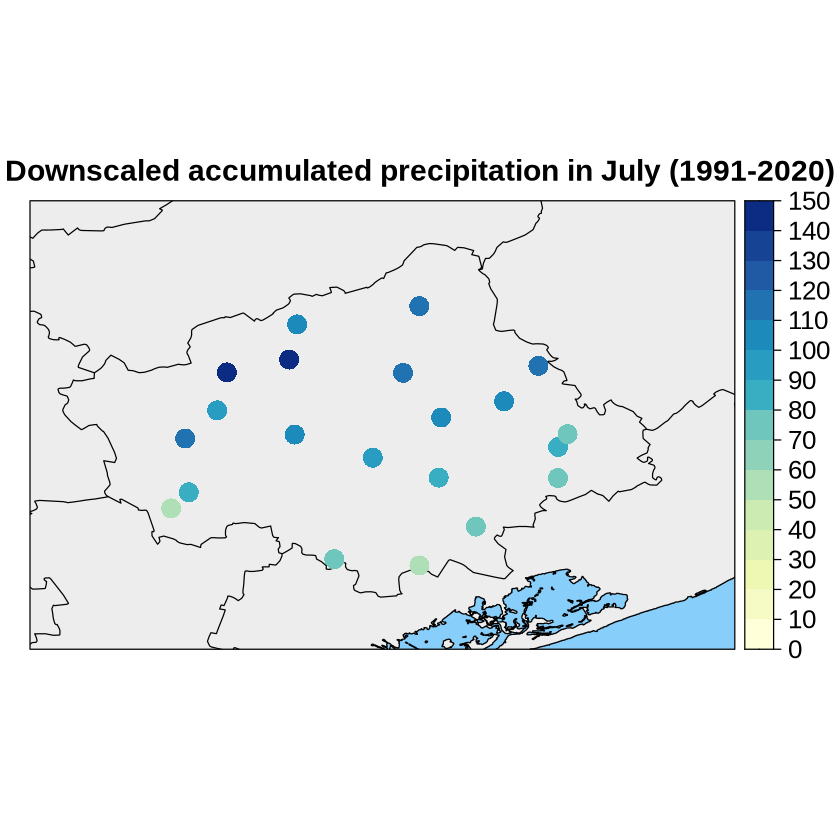

In [14]:
bk <-  seq(0,150,10)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlGnBu"))
cmap <- cols(cmap.nbins)
spatialPlot(climatology(pr_down_hist_jul_sum), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Downscaled accumulated precipitation in July (1991-2020)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

## Downscale GCM in the scenario period

In [15]:
tasmax_down_rcp <- downscale(tasmax_obs, x, newdata = x_rcp_corr, method ="lm", n.pcs = 15)

[2026-02-15 21:32:31.380057] - Scaling ...

[2026-02-15 21:32:34.232132] - Done

[2026-02-15 21:32:34.23359] - Scaling ...

[2026-02-15 21:32:34.841447] - Done



Represent the projected downscaled values for a 30-year period by the end of the century, together with the historical period obtained above:

[2026-02-15 21:32:49.654485] - Computing climatology...

[2026-02-15 21:32:49.657744] - Done.



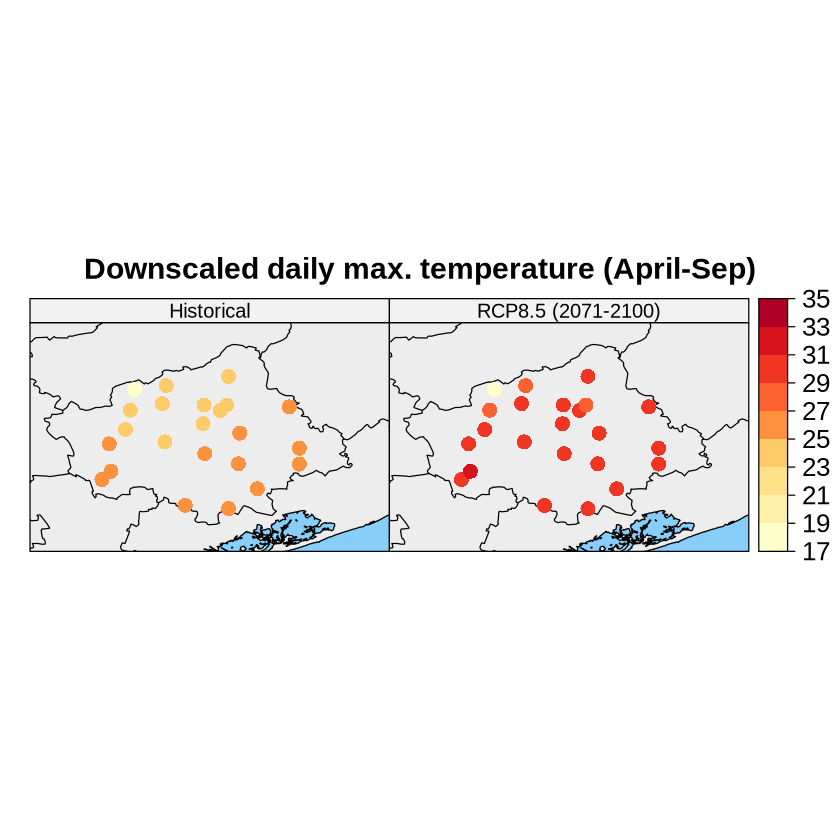

In [16]:
tasmax_down_rcp_subset <- subsetGrid(tasmax_down_rcp, years=2071:2100, season=4:9)
tasmax_down_rcp_mean <- climatology(tasmax_down_rcp_subset)

bk <-  seq(17,35,2)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlOrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(makeMultiGrid(tasmax_down_hist_mean, tasmax_down_rcp_mean, skip.temporal.check = TRUE), cex=1.5, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Downscaled daily max. temperature (April-Sep)", cex=1.5),
    par.strip.text = list(cex = 1), as.table=TRUE, names.attr=c("Historical","RCP8.5 (2071-2100)"), layout= c(2,1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))


And the climate change signal, calculated as the difference of both:

In [17]:
tasmax_down_ccs <- gridArithmetics(tasmax_down_rcp_mean, tasmax_down_hist_mean, operator = "-")

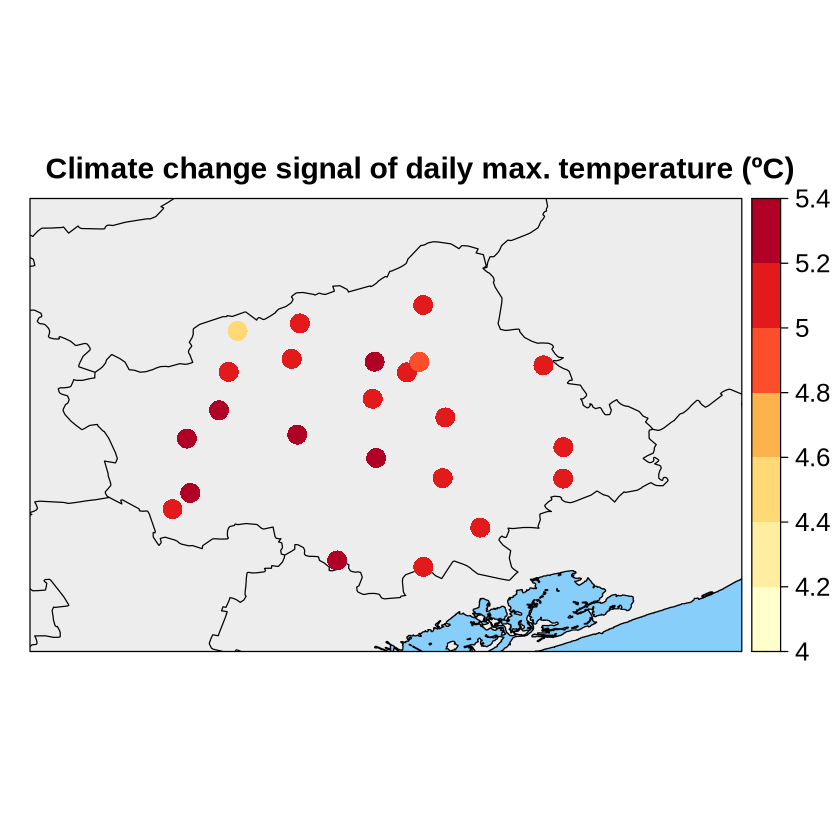

In [18]:
bk <-  seq(4,5.4,0.2)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlOrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(tasmax_down_ccs, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climate change signal of daily max. temperature (ºC)", cex=1.5),
    par.strip.text = list(cex = 1), 
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

Represent transient projections for selected stations:

In [26]:
tasmax_down <- bindGrid(tasmax_down_hist, tasmax_down_rcp, dimension="time")
tasmax_down_agg <- aggregateGrid(subsetGrid(tasmax_down, season=4:9), aggr.y = list(FUN = mean, na.rm = TRUE))

[2026-02-15 21:36:48.017848] Performing annual aggregation...

[2026-02-15 21:36:48.033428] Done.



pad applied on the interval: year



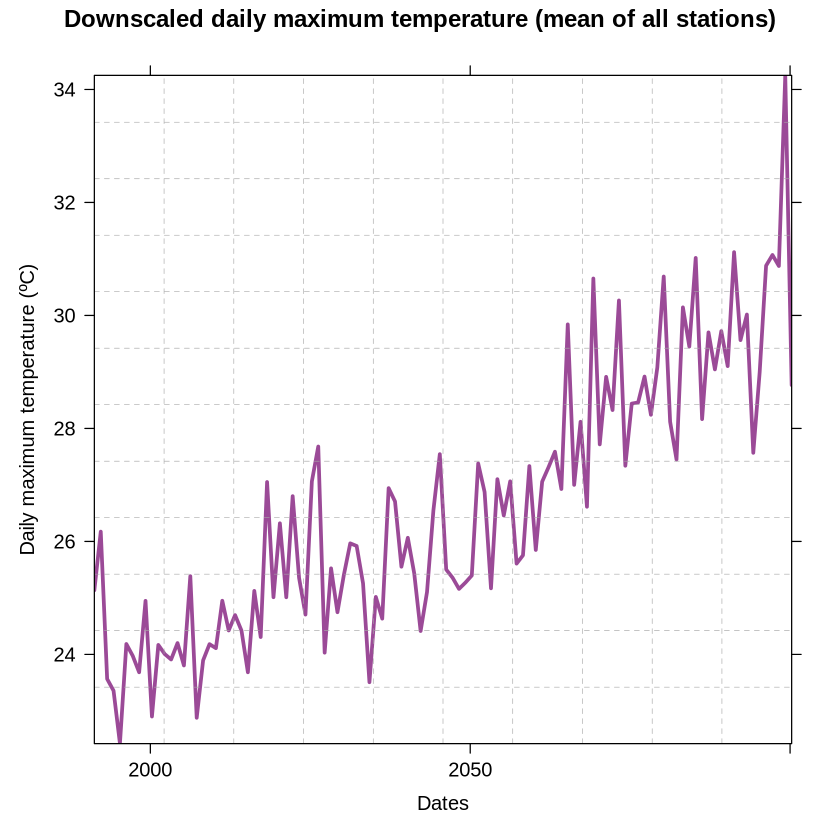

In [27]:
temporalPlot(tasmax_down_agg,
	cols="#9B4A97FF", 
	lwd = 3, 
	xyplot.custom = list(main = "Downscaled daily maximum temperature (mean of all stations)" ,
	ylab= "Daily maximum temperature (ºC)",
	scales=list(x=list(cex=1), y=list(cex=1)), # size of ticks
	key = list( space = "out", points = list(pch= 26), text = list(c("",""), cex = 0.1))
	))

pad applied on the interval: year

pad applied on the interval: year



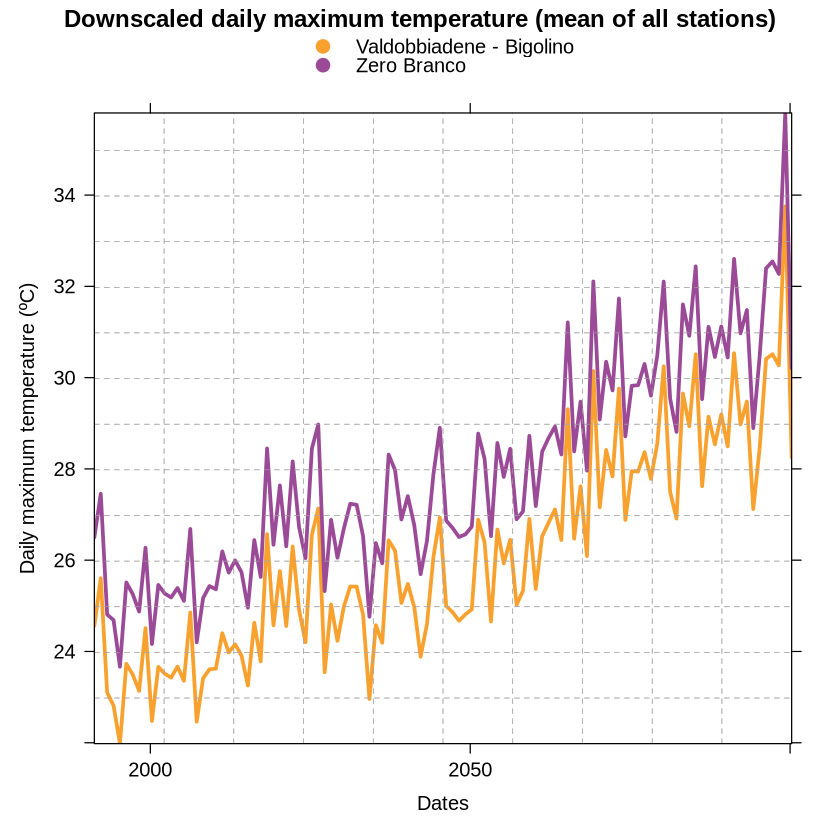

In [ ]:
tasmax_down_stn1 <- subsetGrid(tasmax_down_agg, station.id =189) # ID for Valdobbiadene - Bigolino
tasmax_down_stn2 <- subsetGrid(tasmax_down_agg, station.id =184) # ID for Zero Branco

temporalPlot("Valdobbiadene - Bigolino"=tasmax_down_stn1, "Zero Branco"=tasmax_down_stn2,
	cols=c("#F9A12EFF","#9B4A97FF"),
	lwd = 3, 
	xyplot.custom = list(main = "Downscaled daily maximum temperature (mean of all stations)" ,
	ylab= "Daily maximum temperature (ºC)",
	scales=list(x=list(cex=1), y=list(cex=1)), # size of ticks
	key = list(points = list(pch= 20, cex=2, col=c("#F9A12EFF","#9B4A97FF")), text = list(c("Valdobbiadene - Bigolino","Zero Branco"), cex = 1))))



Example for precipitation. Since the analogs method is more intense computationally, here only a 30-year period is downscaled:

In [22]:
pr_down_rcp <- downscale(pr_obs, x, newdata = subsetGrid(x_rcp_corr, years=2071:2100), method ="analogs", wet.threshold = .1, n.pcs = 15)

[2026-02-15 21:32:51.665476] - Scaling ...

[2026-02-15 21:32:52.493626] - Done

[2026-02-15 21:32:52.494879] - Scaling ...

[2026-02-15 21:32:53.012333] - Done



In [23]:
pr_down_rcp_jul <- subsetGrid(pr_down_rcp, season=7)
pr_down_rcp_jul_sum <- aggregateGrid(pr_down_rcp_jul, aggr.m = list(FUN = sum, na.rm = TRUE))

[2026-02-15 21:33:51.827974] Performing monthly aggregation...

[2026-02-15 21:33:51.829847] Done.



[2026-02-15 21:33:51.843015] - Computing climatology...

[2026-02-15 21:33:51.843982] - Done.

[2026-02-15 21:33:51.846159] - Computing climatology...

[2026-02-15 21:33:51.847426] - Done.



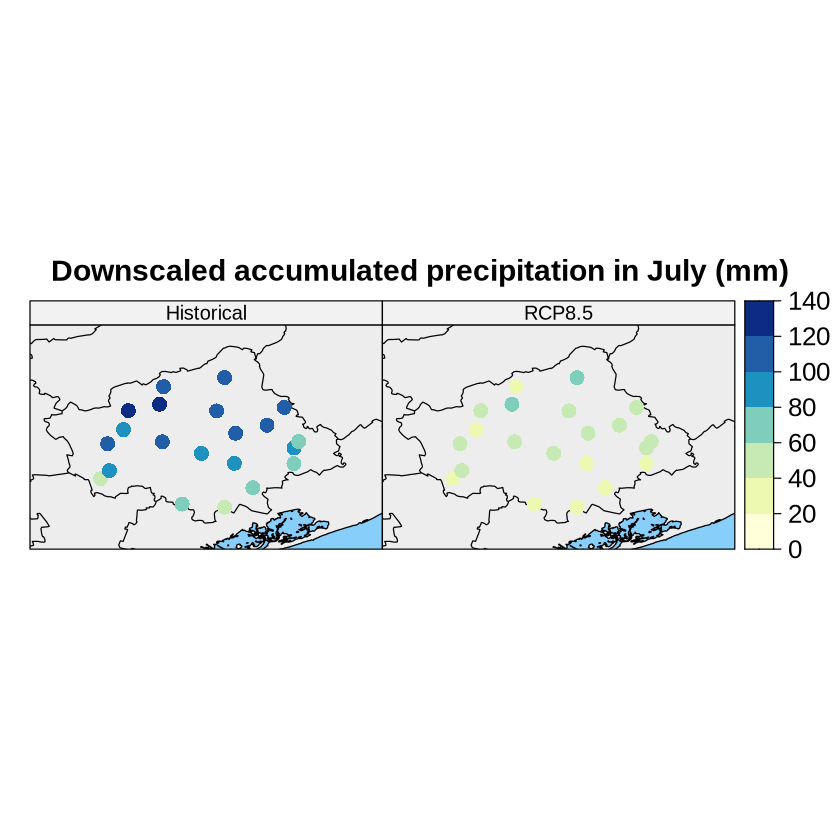

In [24]:
bk <-  seq(0,150,20)
cmap.nbins = length(bk)  # number of bins in colorbar
cols = colorRampPalette(brewer.pal(8,"YlGnBu"))
cmap = cols(cmap.nbins)
spatialPlot(makeMultiGrid(climatology(pr_down_hist_jul_sum), climatology(pr_down_rcp_jul_sum), skip.temporal.check = TRUE), cex=1.5, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Downscaled accumulated precipitation in July (mm)", cex=1.5),
    par.strip.text = list(cex = 1), as.table=TRUE, names.attr=c("Historical","RCP8.5"), layout= c(2,1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

And the climate change signal in relative terms:

[2026-02-15 21:33:52.632323] - Computing climatology...

[2026-02-15 21:33:52.634349] - Done.

[2026-02-15 21:33:52.636653] - Computing climatology...

[2026-02-15 21:33:52.637784] - Done.

[2026-02-15 21:33:52.90335] - Computing climatology...

[2026-02-15 21:33:52.90449] - Done.



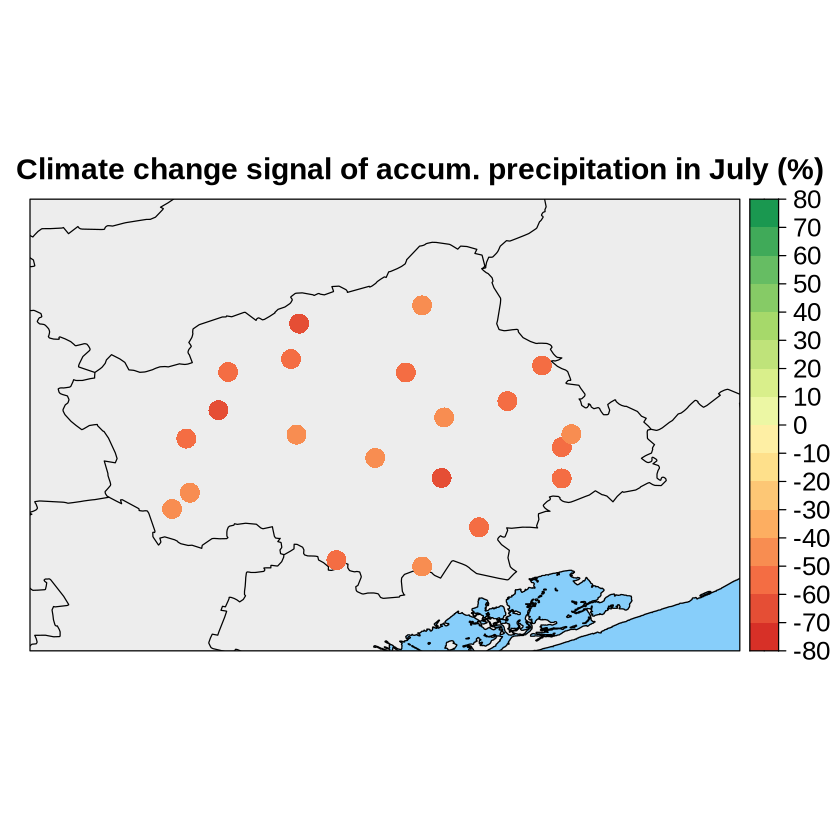

In [25]:
pr_down_ccs <- gridArithmetics(climatology(pr_down_rcp_jul_sum), climatology(pr_down_hist_jul_sum), climatology(pr_down_hist_jul_sum), 100, operator=c("-", "/", "*"))
bk <- seq(-80, 80, 10)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(9,"RdYlGn"))
cmap <- cols(cmap.nbins)
spatialPlot(pr_down_ccs, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk,  main = list(label="Climate change signal of accum. precipitation in July (%)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))